# GRU Decoder with Masked Self-Attention

This notebook introduces **masked self-attention inside the decoder** before running the GRU update. The encoder from the
previous step is reused, so the decoder now reasons about previously generated tokens via causal masking while still relying
on the recurrent state for temporal continuity.


In [ ]:
import os
import torch
from torch import nn
from d2l import torch as d2l
from tsv_seq2seq_data import TSVSeq2SeqData

import importlib
import hw7
importlib.reload(hw7)
from hw7 import *

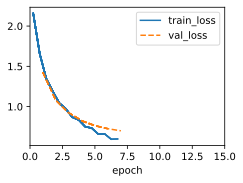

In [ ]:
from tsv_seq2seq_data import TSVSeq2SeqData
data_path = os.path.expanduser('~/Dropbox/CS6140/data/sentence_pairs_large.tsv')
data = TSVSeq2SeqData(
    path=data_path,
    batch_size=512,
    num_steps=25,
    min_freq=2,
    val_frac=0.05,
    test_frac=0.0,
    sample_percent=1,
)

embed_size = 320
num_hiddens = 320 
num_blks = 3 
num_layers =3
dropout = 0.35 
num_heads = 4

encoder = SelfAttentionAugmentedEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers,
                                         num_heads=num_heads, dropout=dropout)
decoder = SelfAttentiveGRUDecoder(len(data.tgt_vocab), embed_size,
                                  num_hiddens, num_layers, num_heads=num_heads, dropout=dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.001)
trainer = d2l.Trainer(max_epochs=15, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)


In [3]:
# examples = ['necesito ayuda urgente .', 'ayer llovio mucho en la ciudad .', 'los ninos estan jugando en el parque .', 'ella quiere aprender a hablar ingles muy bien .', 'cuando llegara el proximo tren a madrid ?']
# references = ['i need urgent help .', 'it rained a lot in the city yesterday .', 'the children are playing in the park .', 'she wants to learn to speak english very well .', 'when will the next train to madrid arrive ?']

# preds, _ = model.predict_step(
#     data.build(examples, references), d2l.try_gpu(), data.num_steps)
# for src, tgt, pred in zip(examples, references, preds):
#     translation = []
#     for token in data.tgt_vocab.to_tokens(pred):
#         if token == '<eos>':
#             break
#         translation.append(token)
#     print(f"{src} => {' '.join(translation)} | reference: {tgt}")


examples = ['vamos .', 'me perdi .', 'esta tranquilo .', 'estoy en casa .', 'donde esta el tren ?',    'necesito ayuda urgente .',
    'ayer llovio mucho en la ciudad .', 'los ninos estan jugando en el parque .', 'ella quiere aprender a hablar ingles muy bien .',
    'cuando llegara el proximo tren a madrid ?']

references = ['go .', 'i got lost .', 'he is calm .', 'i am at home .', 'where is the train ?',
    'i need urgent help .', 'it rained a lot in the city yesterday .',
    'the children are playing in the park .', 'she wants to learn to speak english very well .', 'when will the next train to madrid arrive ?']

preds, _ = model.predict_step(
    data.build(examples, references), d2l.try_gpu(), data.num_steps)
for src, tgt, pred in zip(examples, references, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(pred):
        if token == '<eos>':
            break
        translation.append(token)
    
    hypo = ' '.join(translation)
    print(f"{src} => {hypo}    |  reference: {tgt}  | BLEU: {d2l.bleu(hypo, tgt, k=2):.3f}")

vamos . => let's get free.    |  reference: go .  | BLEU: 0.000
me perdi . => i will give me a ticket.    |  reference: i got lost .  | BLEU: 0.000
esta tranquilo . => this <unk>    |  reference: he is calm .  | BLEU: 0.000
estoy en casa . => i'm in the classroom.    |  reference: i am at home .  | BLEU: 0.000
donde esta el tren ? => where is the train tomorrow?    |  reference: where is the train ?  | BLEU: 0.832
necesito ayuda urgente . => i need to pay you free.    |  reference: i need urgent help .  | BLEU: 0.386
ayer llovio mucho en la ciudad . => yesterday i was a lot of summer in the summer.    |  reference: it rained a lot in the city yesterday .  | BLEU: 0.485
los ninos estan jugando en el parque . => the <unk> <unk> playing on the new room.    |  reference: the children are playing in the park .  | BLEU: 0.000
ella quiere aprender a hablar ingles muy bien . => she wants to learn to learn a lot of spanish.    |  reference: she wants to learn to speak english very well .  | BLE